# Basic LSTM
This is a basic LSTM following the guide at [link text](https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091)


## Forget gate
### Decides what to delete from the past
The forget gate controls how much of the past memory we consider by passing the current input through a sigmoid function together with the hidden layer and bias, and then multiplying it by the previous cell state C_t-1. A smaller value means less relevance of the memory, while a bigger value means more relevance.

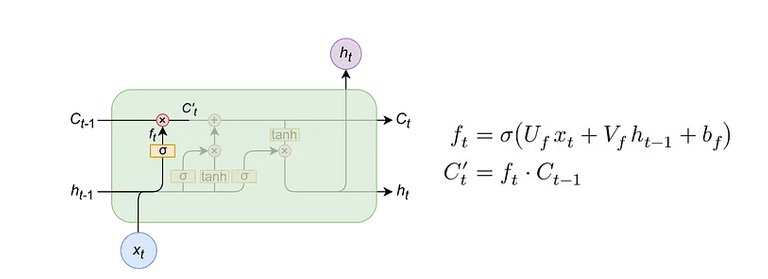

## Input gate
### Decides what to add to the memory from the present
The input gate is where the information contained on the input and hidden state is combined and then operated along with the candidate and partial candidate c'_t, to calculate how much the current information will be relevant to put inside the cell state \
The candidate is a value that represents how much information will be added into the cell state \
On those operations, it is decided how much of the new information will be introduced on the memory and how it will change — that’s why we use a tanh function (“scale” from -1 to 1). We combine the partial candidate from the short-term and long-term memories and set it as the candidate, so that the candidate is influenced by the input gate i_t.


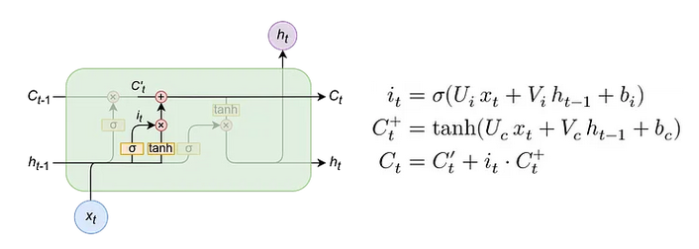

## Output gate
### Decides how much of the current memory should be shared as hidden state
The output gate takes the updated cell state (C_t​), applies a tanh⁡tanh function to scale its values between −1 and 1, and then multiplies this by o_t​ (the output gate's activation vector). This produces the hidden state. The hidden state (h_t​) represents the short-term memory that is immediately relevant for making predictions or decisions at the current time step.
Remember: cell state is private while hidden state is shared


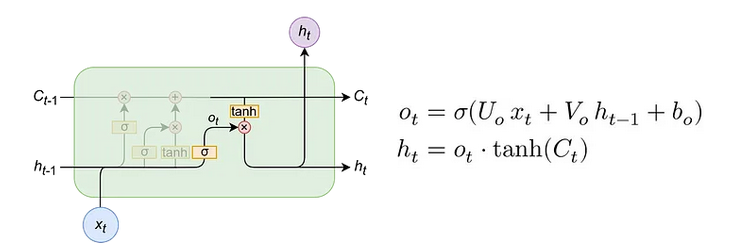

## Recap of the equations

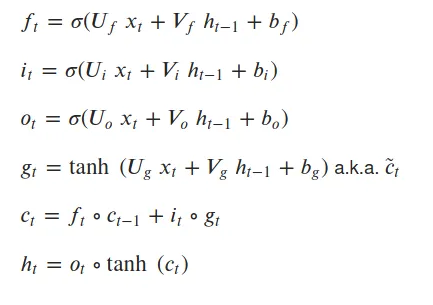

In [ ]:
import math
import torch
import torch.nn as nn

## Initialize the LSTM model

In [ ]:
class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        #Weights declaration for every gate
        #i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        #f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        #c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        #o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()


In [ ]:
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

## Feedforward operation

The feedforward operation receives the init_states parameter, which is a tuple with the (h_t, c_t) parameters of the equations above, which is set to zero if not introduced. We then perform the feedforward of the LSTM equations for each of the sequence elements preserving the (h_t, c_t), and introducing it as the states for the next element of the sequence. \
At the end, we return the predictions and the last states tuple.

In [ ]:
    def forward(self,
                    x,
                    init_states=None):

            """
            assumes x.shape represents (batch_size, sequence_size, input_size)
            -Batch size: number of examples / data points
            -Sequence size: how many time steps per data point there are
            -Input size: number of features for each data point
            """

            bs, seq_sz, _ = x.size()
            hidden_seq = []

            if init_states is None:
                h_t, c_t = (
                    torch.zeros(bs, self.hidden_size).to(x.device),
                    torch.zeros(bs, self.hidden_size).to(x.device),
                )
            else:
                h_t, c_t = init_states

            for t in range(seq_sz): #for each time stamp
                x_t = x[:, t, :] #at each timestamp we extract the corresponding slice x[batch_size, input_size]

                i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
                f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
                g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
                o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)

                hidden_seq.append(h_t.unsqueeze(0)) #hidden_seq will contain all the hidden states at all
                #time stamps for each sequence

            #reshape hidden_seq p/ retornar
            hidden_seq = torch.cat(hidden_seq, dim=0) #concatenate hidden states in one large tensor
            hidden_seq = hidden_seq.transpose(0, 1).contiguous()
            return hidden_seq, (h_t, c_t) #return hidden sequence and last time stamp (h_t, c_t)

This LSTM is correct in terms of operations but not very optimized in terms of computational time: we perform 8 matrix multiplications separately, which is much slower than doing it in a vectorized way. We will now show how it could be done by reducing it to 2 matrix multiplications, which would make it much faster.

To do this operations, we set two matrixes, U and V, which have the weight contained on the 4 matrix multiplications each of they do. We then perform the gated operations on the matrixes that already passed per the linear combinations + bias operation.

With the vectorized operations, the equations of the LSTM cell would be:

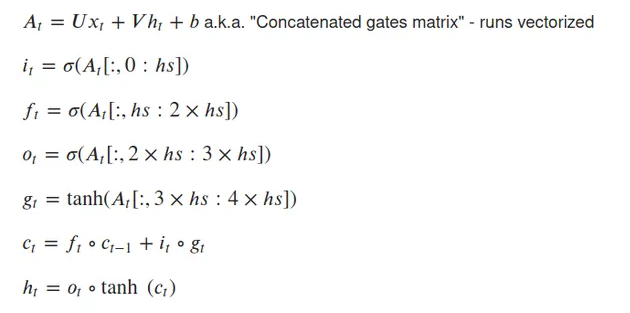

# Optimized LSTM

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import math

In [7]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz

        # Projection layer to adjust input to hidden size
        self.input_projection = nn.Linear(input_sz, hidden_sz)

        self.W = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()

        # Prediction head to map back to original input size
        self.fc = nn.Linear(hidden_sz, input_sz)

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, input_features = x.size()

        # Project input to hidden size
        x_projected = self.input_projection(x)

        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x_projected[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))

        # Use the last hidden state for prediction
        prediction = self.fc(h_t)

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return prediction, (h_t, c_t)

# Loading the data

In [15]:
#execute only if you're using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
file_path = '/content/drive/MyDrive/lstm_dataset5.pt'

In [24]:
def load_data(data_path):
    data = torch.load(data_path, weights_only=True)
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    X_test, y_test = data['X_test'], data['y_test']

    return X_train, y_train, X_val, y_val, X_test, y_test

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data(file_path)

In [30]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # List of tensors for inputs
        self.y = y  # List of tensors for targets

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [32]:
def collate_fn(batch):
    # Batch is a list of tuples: (X, y)
    X_batch, y_batch = zip(*batch)

    # Pad sequences to the maximum length in the batch
    X_padded = pad_sequence(X_batch, batch_first=True, padding_value=0)
    y_padded = pad_sequence(y_batch, batch_first=True, padding_value=0)

    lengths = torch.tensor([torch.count_nonzero(x[:, 0]) for x in X_batch])

    return X_padded, y_padded, lengths

In [33]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

# Basic training loop

In [54]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch, lengths in train_loader:  # Unpack lengths here

            # Merge `num_windows` with `batch_size`
            bs, nw, seq_len, feature_dim = X_batch.shape
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)

            # Adjust y_batch accordingly
            y_batch = y_batch.view(bs * nw, -1)

            # Pass reshaped inputs to the model
            output, _ = model(X_batch)

            # Compute the loss
            loss = criterion(output, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch, lengths in val_loader:  # Unpack lengths here as well
                # Merge `num_windows` with `batch_size`
                bs, nw, seq_len, feature_dim = X_batch.shape
                X_batch = X_batch.view(bs * nw, seq_len, feature_dim)

                # Adjust y_batch accordingly
                y_batch = y_batch.view(bs * nw, -1)

                # Pass reshaped inputs to the model
                output, _ = model(X_batch)

                # Compute the loss
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomLSTM(input_sz=8, hidden_sz=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/100, Train Loss: 0.4477, Val Loss: 0.4516
Epoch 2/100, Train Loss: 0.4970, Val Loss: 0.4253
Epoch 3/100, Train Loss: 0.3427, Val Loss: 0.3937
Epoch 4/100, Train Loss: 0.4155, Val Loss: 0.3573
Epoch 5/100, Train Loss: 0.3265, Val Loss: 0.3199
Epoch 6/100, Train Loss: 0.2506, Val Loss: 0.2880
Epoch 7/100, Train Loss: 0.3659, Val Loss: 0.2598
Epoch 8/100, Train Loss: 0.1977, Val Loss: 0.2393
Epoch 9/100, Train Loss: 0.1783, Val Loss: 0.2208
Epoch 10/100, Train Loss: 0.1836, Val Loss: 0.2061
Epoch 11/100, Train Loss: 0.2176, Val Loss: 0.1917
Epoch 12/100, Train Loss: 0.1725, Val Loss: 0.1763
Epoch 13/100, Train Loss: 0.1459, Val Loss: 0.1590
Epoch 14/100, Train Loss: 0.2379, Val Loss: 0.1464
Epoch 15/100, Train Loss: 0.1368, Val Loss: 0.1337
Epoch 16/100, Train Loss: 0.1575, Val Loss: 0.1217
Epoch 17/100, Train Loss: 0.1460, Val Loss: 0.1107
Epoch 18/100, Train Loss: 0.2636, Val Loss: 0.1028
Epoch 19/100, Train Loss: 0.1043, Val Loss: 0.0950
Epoch 20/100, Train Loss: 0.1410, Val Lo

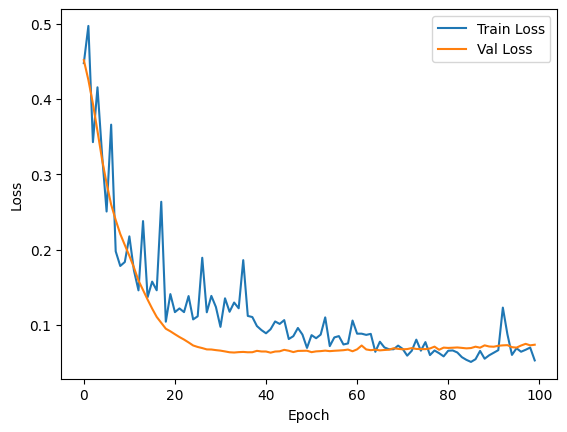

In [59]:
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
def compare_predictions_truncated(model, test_loader, device, num_samples=3, feature_count=8):
    """
    Compare true and predicted values numerically, truncated to expected feature count.

    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test set.
        device: The device (CPU or GPU).
        num_samples: Number of samples to display.
        feature_count: Number of features expected per trajectory (default: 8).
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for idx, (X_batch, y_batch, lengths) in enumerate(test_loader):
            if idx > 0:  # Limit to just the first batch for visualization
                break
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Reshape X_batch and y_batch as done during training
            bs, nw, seq_len, feature_dim = X_batch.shape
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)
            y_batch = y_batch.view(bs * nw, -1)

            # Get predictions
            y_pred, _ = model(X_batch)

            # Reshape predictions and ground truth back for comparison
            y_pred = y_pred.view(bs, nw, -1).cpu()
            y_truth = y_batch.view(bs, nw, -1).cpu()

            # Truncate predictions and truth based on expected feature count
            y_truth = y_truth[:, :, :feature_count]
            y_pred = y_pred[:, :, :feature_count]

            # Print numerical comparison for `num_samples` trajectories
            for i in range(min(num_samples, bs)):
                print(f"Sample {i + 1}:")
                print("y_truth:", y_truth[i, :, :].numpy().tolist())
                print("y_pred :", y_pred[i, :, :].numpy().tolist())
                print("-" * 50)

# Call this after training
compare_predictions_truncated(model, test_loader, device, num_samples=3, feature_count=8)


Sample 1:
y_truth: [[-0.2935546636581421, 0.22753481566905975, 0.0, 0.0, 0.0, 0.33875325322151184, 0.11827382445335388, 0.12510165572166443], [-0.2078665792942047, 0.2495720088481903, 0.0, 0.0, 0.0, 0.36055275797843933, 0.11827382445335388, 0.08001591265201569], [-0.12254616618156433, 0.2738768756389618, 0.0, 0.0, 0.0, 0.3730262219905853, 0.11827382445335388, 0.056186575442552567], [-0.03753599151968956, 0.2994629442691803, 0.0, 0.0, 0.0, 0.3805590569972992, 0.11827382445335388, 0.04386061429977417], [0.0474071279168129, 0.32589593529701233, 0.0, 0.0, 0.0, 0.38542571663856506, 0.11827382445335388, 0.02610846608877182], [0.13214139640331268, 0.35294097661972046, 0.0, 0.0, 0.0, 0.3905029594898224, 0.11827382445335388, 0.05819357931613922], [0.21580606698989868, 0.3845165967941284, 0.0, 0.0, 0.0, 0.4491861164569855, 0.11827382445335388, 0.16794756054878235], [0.2980649769306183, 0.4219653010368347, 0.0, 0.0, 0.0, 0.4788765013217926, 0.11827382445335388, 0.09240975975990295], [0.3795476257

# Testing loop

In [69]:
def test_model(model, test_loader, criterion, device, feature_count=8):
    """
    Test the model on the test dataset and print metrics and sample predictions.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        criterion: Loss function used during training (e.g., MSELoss).
        device: Device (CPU or GPU).
        feature_count: Number of features to compare in predictions.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    all_y_truth = []
    all_y_pred = []

    with torch.no_grad():  # Disable gradient calculations
        for X_batch, y_batch, lengths in test_loader:
            # Move data to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Reshape batches if necessary (depending on your training setup)
            bs, nw, seq_len, feature_dim = X_batch.shape
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)
            y_batch = y_batch.view(bs * nw, -1)

            # Forward pass
            y_pred, _ = model(X_batch)

            # Reshape predictions and ground truth for comparison
            y_pred = y_pred.view(bs, nw, -1)
            y_batch = y_batch.view(bs, nw, -1)

            # Calculate loss for the batch
            loss = criterion(y_pred[:, :, :feature_count], y_batch[:, :, :feature_count])
            test_loss += loss.item()

            # Store predictions and ground truth for further analysis
            all_y_truth.append(y_batch[:, :, :feature_count].cpu())
            all_y_pred.append(y_pred[:, :, :feature_count].cpu())

    # Compute average loss over the test set
    avg_test_loss = test_loss / len(test_loader)

    # Convert predictions and truth to a format suitable for analysis
    all_y_truth = torch.cat(all_y_truth, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    print(f"Test Loss: {avg_test_loss:.4f}")

    # Display a few examples
    num_samples = 3
    print("\nSample Predictions:")
    for i in range(min(num_samples, all_y_truth.shape[0])):
        print(f"Sample {i + 1}:")
        print("y_truth:", all_y_truth[i].tolist())
        print("y_pred :", all_y_pred[i].tolist())
        print("-" * 50)

# Example usage
test_model(model, test_loader, criterion, device, feature_count=8)


Test Loss: 0.0033

Sample Predictions:
Sample 1:
y_truth: [[-0.2935546636581421, 0.22753481566905975, 0.0, 0.0, 0.0, 0.33875325322151184, 0.11827382445335388, 0.12510165572166443], [-0.2078665792942047, 0.2495720088481903, 0.0, 0.0, 0.0, 0.36055275797843933, 0.11827382445335388, 0.08001591265201569], [-0.12254616618156433, 0.2738768756389618, 0.0, 0.0, 0.0, 0.3730262219905853, 0.11827382445335388, 0.056186575442552567], [-0.03753599151968956, 0.2994629442691803, 0.0, 0.0, 0.0, 0.3805590569972992, 0.11827382445335388, 0.04386061429977417], [0.0474071279168129, 0.32589593529701233, 0.0, 0.0, 0.0, 0.38542571663856506, 0.11827382445335388, 0.02610846608877182], [0.13214139640331268, 0.35294097661972046, 0.0, 0.0, 0.0, 0.3905029594898224, 0.11827382445335388, 0.05819357931613922], [0.21580606698989868, 0.3845165967941284, 0.0, 0.0, 0.0, 0.4491861164569855, 0.11827382445335388, 0.16794756054878235], [0.2980649769306183, 0.4219653010368347, 0.0, 0.0, 0.0, 0.4788765013217926, 0.118273824453353